In [1496]:
import sys

# Navigate up two directories to the project root, then to src/components
module_path = '../../src/components'
if module_path not in sys.path:
    sys.path.append(module_path)

# Now import the PostgreSQLIngestion class
from data_ingestion import PostgreSQLIngestion


In [1497]:
# Configuration for database connection
db_config = {
    'host': 'localhost',
    'port': 5432,
    'dbname': 'truckdb',
    'user': 'postgres',
    'password': 'mysecretpassword'
}

# Create an instance of the ingestion class
ingestion = PostgreSQLIngestion(db_config)


In [1504]:

ingestion.connect()

drivers_df = ingestion.fetch_data('drivers')
if drivers_df is None:
    print("Failed to fetch data. DataFrame is None.")
else:
    print(drivers_df.head())

Database connection successful.
Error fetching data from table drivers: 'Engine' object has no attribute 'cursor'
Failed to fetch data. DataFrame is None.


/Users/jeevanapathipati/Documents/TruckDelay/notebooks/../src/components/data_ingestion.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, self.engine)


In [ ]:

drivers_df.dropna(inplace=True)
drivers_df['experience'] = drivers_df['experience'].astype(int)

In [1502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.impute import KNNImputer


In [1503]:
# Use the instance to fetch data directly
drivers_df = ingestion.fetch_data('drivers')
drivers_df.head()

Error fetching data from table drivers: 'NoneType' object has no attribute 'cursor'


AttributeError: 'NoneType' object has no attribute 'head'

# Data Cleaning Notebook
This notebook contains automated data cleaning procedures for multiple datasets related to a transportation project. The processes include removing unwanted columns, handling missing values, detecting and removing outliers, and visualizing data distributions.

In [1433]:

# Function to drop unwanted columns
def drop_columns(df, columns):
    if isinstance(columns, str):
        columns = [columns]  # Convert a single column name into a list
    return df.drop(columns=columns)


def remove_duplicates(df):
    # Remove duplicates while keeping the first occurrence
    return df.drop_duplicates(keep='first')


# Function to handle missing values
def filling_missing_values(dataframe, n_neighbors=5):
    # Create imputer instances
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Separate numeric and non-numeric columns
    numeric_cols = dataframe.select_dtypes(include=['number']).columns
    non_numeric_cols = dataframe.select_dtypes(include=['object']).columns
    
    # Process numeric columns
    for col in numeric_cols:
        if dataframe[col].isnull().sum() > 0:
            # Apply KNN imputer to numeric columns with missing values
            dataframe[col] = knn_imputer.fit_transform(dataframe[[col]])
    
    # Process non-numeric columns
    for col in non_numeric_cols:
        if dataframe[col].isnull().sum() > 0:
            # Apply mode imputation
            mode_value = dataframe[col].mode()[0]  # Get the most frequent value
            dataframe[col]=dataframe[col].fillna(mode_value)
    
    
    return dataframe
# def handle_missing_values(df, columns, method='mean'):
#     if isinstance(columns, str):
#         columns = [columns]  # Convert a single column name into a list
#     for column in columns:
#         if method == 'drop':
#             df = df.dropna(subset=[column])
#         elif method == 'mean':
#             if df[column].dtype in ['float64', 'int64']:
#                 df[column] = df[column].fillna(df[column].mean())
#         elif method == 'median':
#             if df[column].dtype in ['float64', 'int64']:
#                 df[column] = df[column].fillna(df[column].median())
#         elif method == 'mode':
#             df[column] = df[column].fillna(df[column].mode()[0])
#     return df


# # Function to detect and handle outliers using IQR
def remove_outliers(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    # Calculate IQR for each numerical column
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the non-outlier data
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataframe to remove outliers based on the bounds
    # Apply bounds to each column individually
    filter_conditions = (df[numerical_cols] >= lower_bound) & (df[numerical_cols] <= upper_bound)
    filtered_df = df[filter_conditions.all(axis=1)]  # Keep rows where all conditions are true
    
    return filtered_df


def display_unique_values(df, columns=None):
    if columns is None:  # If no specific columns are provided, use all columns
        columns = df.columns

    for column in columns:
        if column in df.columns:  # Check if the specified column exists in the DataFrame
            unique_vals = df[column].unique()
            unique_count = len(unique_vals)
            print(f"Unique values in '{column}' ({unique_count} total):")
            print(unique_vals) # Display all unique values, sorted for better readability
        else:
            print(f"Column '{column}' does not exist in the DataFrame.")


import pandas as pd

def combine_date_hour(df, date_col, hour_col, new_col_name='datetime', default_sec='00'):
   
    # Convert hour column to string and ensure it is zero-padded to four digits
    df[hour_col] = df[hour_col].astype(str).str.zfill(4)

    # Combine the date and hour columns into a datetime column
    df[new_col_name] = pd.to_datetime(df[date_col].astype(str) + ' ' +
                                      df[hour_col].str.slice(0, 2) + ':' +
                                      df[hour_col].str.slice(2, 4) + ':' +
                                      default_sec)

    return df

def convert_estimated_arrival(dataframe, column_name):
    # Convert the specified column to datetime
    dataframe[column_name] = pd.to_datetime(dataframe[column_name])
    
    # Remove milliseconds from the datetime
    dataframe[column_name] = dataframe[column_name].dt.floor('s')
    
    return dataframe

        

def add_index_and_eventtime_columns(df):
    # Create an index column with integer data type
    df['index'] = range(len(df))
    
    # Create an eventtime column with the current date
    # Ensure the column is of datetime type
    df['eventtime'] = pd.to_datetime(pd.Timestamp.now().date())
    
    return df





In [1434]:
# Function to visualize data
def visualize_data(df, columns):
    if isinstance(columns, str):
        columns = [columns]  # Convert a single column name into a list
    num_cols = len(columns)
    if num_cols == 1:
        plt.figure(figsize=(6, 4))  # Set figure size for a single plot
        sns.boxplot(x=df[columns[0]])
        plt.title(f'Distribution of {columns[0]}')
        plt.show()
    else:
        fig, axes = plt.subplots(1, num_cols, figsize=(6 * num_cols, 4))  # Adjust the size based on the number of columns
        for i, column in enumerate(columns):
            sns.boxplot(x=df[column], ax=axes[i])
            axes[i].set_title(f'Distribution of {column}')
        plt.tight_layout()
        plt.show()

City Weather Data Cleaning

In [1208]:
city_weather = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/city_weather.csv')

In [1209]:
city_weather.head(6)

,city_id,date,hour,temp,wind_speed,description,precip,humidity,visibility,pressure,chanceofrain,chanceoffog,chanceofsnow,chanceofthunder
0,C-927ceb5e,2019-01-01,0,30,11,Light snow,0.0,86,6,1019,0,0,0,0
1,C-927ceb5e,2019-01-01,100,28,12,Light snow,0.0,86,5,1021,0,0,0,0
2,C-927ceb5e,2019-01-01,200,28,13,Moderate snow,0.0,85,4,1022,0,0,0,0
3,C-927ceb5e,2019-01-01,300,28,14,Moderate snow,0.0,84,3,1024,0,0,0,0
4,C-927ceb5e,2019-01-01,400,28,13,Moderate snow,0.0,84,3,1025,0,0,0,0
5,C-927ceb5e,2019-01-01,500,27,12,Moderate snow,0.0,84,3,1026,0,0,0,0


In [1210]:
city_weather.shape

(55176, 14)

In [1211]:
city_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55176 entries, 0 to 55175
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city_id          55176 non-null  object 
 1   date             55176 non-null  object 
 2   hour             55176 non-null  int64  
 3   temp             55176 non-null  int64  
 4   wind_speed       55176 non-null  int64  
 5   description      55176 non-null  object 
 6   precip           55176 non-null  float64
 7   humidity         55176 non-null  int64  
 8   visibility       55176 non-null  int64  
 9   pressure         55176 non-null  int64  
 10  chanceofrain     55176 non-null  int64  
 11  chanceoffog      55176 non-null  int64  
 12  chanceofsnow     55176 non-null  int64  
 13  chanceofthunder  55176 non-null  int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 5.9+ MB


In [1212]:
city_weather.columns

Index(['city_id', 'date', 'hour', 'temp', 'wind_speed', 'description',
       'precip', 'humidity', 'visibility', 'pressure', 'chanceofrain',
       'chanceoffog', 'chanceofsnow', 'chanceofthunder'],
      dtype='object')

In [1213]:
city_weather.isnull().sum()

city_id            0
date               0
hour               0
temp               0
wind_speed         0
description        0
precip             0
humidity           0
visibility         0
pressure           0
chanceofrain       0
chanceoffog        0
chanceofsnow       0
chanceofthunder    0
dtype: int64

In [1214]:
city_weather = combine_date_hour(city_weather, 'date', 'hour')

Drop the unnecessary columns

In [1215]:
city_weather = drop_columns(city_weather, ['chanceofrain',
       'chanceoffog', 'chanceofsnow', 'chanceofthunder'])

In [1216]:
city_weather = remove_duplicates(city_weather)

In [1217]:
city_weather.head(5)

,city_id,date,hour,temp,wind_speed,description,precip,humidity,visibility,pressure,datetime
0,C-927ceb5e,2019-01-01,0000,30,11,Light snow,0.0,86,6,1019,2019-01-01 00:00:00
1,C-927ceb5e,2019-01-01,0100,28,12,Light snow,0.0,86,5,1021,2019-01-01 01:00:00
2,C-927ceb5e,2019-01-01,0200,28,13,Moderate snow,0.0,85,4,1022,2019-01-01 02:00:00
3,C-927ceb5e,2019-01-01,0300,28,14,Moderate snow,0.0,84,3,1024,2019-01-01 03:00:00
4,C-927ceb5e,2019-01-01,0400,28,13,Moderate snow,0.0,84,3,1025,2019-01-01 04:00:00


In [1218]:
city_weather.columns

Index(['city_id', 'date', 'hour', 'temp', 'wind_speed', 'description',
       'precip', 'humidity', 'visibility', 'pressure', 'datetime'],
      dtype='object')

In [1219]:
#city_weather = handle_missing_values(city_weather, method='fill')

In [1220]:
display_unique_values(city_weather)

Unique values in 'city_id' (49 total):
['C-927ceb5e' 'C-56e39a5e' 'C-73ae5412' 'C-4fe0fa24' 'C-451776b7'
 'C-d80a1e7d' 'C-c92599e2' 'C-731988ba' 'C-639c5e36' 'C-a9f2c329'
 'C-c7cacd1d' 'C-ef47bdcd' 'C-84f378bb' 'C-c4565ee8' 'C-6ea51d66'
 'C-ff8c0c3c' 'C-e5bfb4e5' 'C-3dbd8b2e' 'C-7212cebe' 'C-b6e04c88'
 'C-01660979' 'C-f8f01604' 'C-280b55fb' 'C-f5ed4c15' 'C-6df8beaf'
 'C-2bd47dc5' 'C-b25a09de' 'C-419cd14c' 'C-9bbf5d8a' 'C-40a81eb1'
 'C-2c9e75ef' 'C-03bb3e48' 'C-19236709' 'C-fc66f0ab' 'C-b5ff31cd'
 'C-5d86b887' 'C-2aaf0e1a' 'C-34ae77b0' 'C-d9e9d934' 'C-b5282c3b'
 'C-d3bb431c' 'C-825b2625' 'C-90e30162' 'C-2e349ccd' 'C-56b68559'
 'C-328bd8d3' 'C-841ebdcb' 'C-e6dcda92' 'C-594514f8']
Unique values in 'date' (46 total):
['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15'
 '2019-01-16' '2019-01-17' '2019-01-18' '2019-01-19' '2019-01-20'
 '2019-01-21'

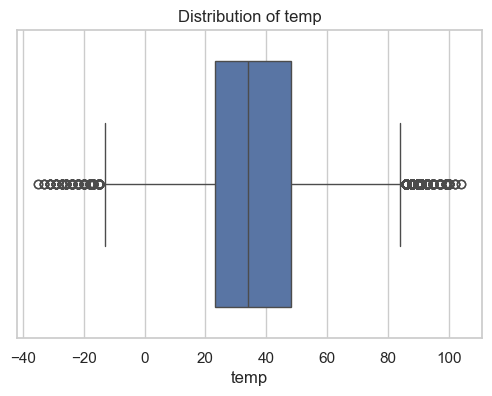

In [1221]:
visualize_data(city_weather, 'temp')

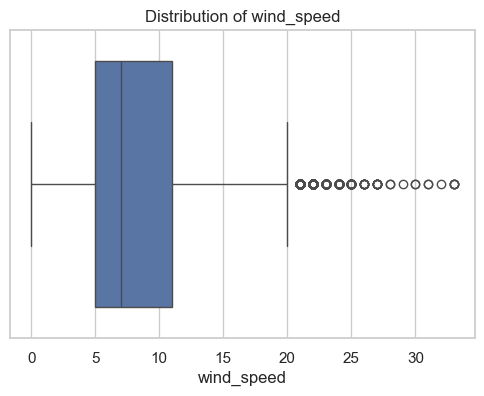

In [1222]:
visualize_data(city_weather, 'wind_speed')

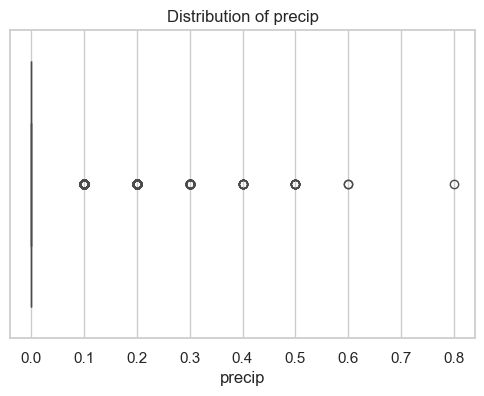

In [1223]:
visualize_data(city_weather, 'precip')

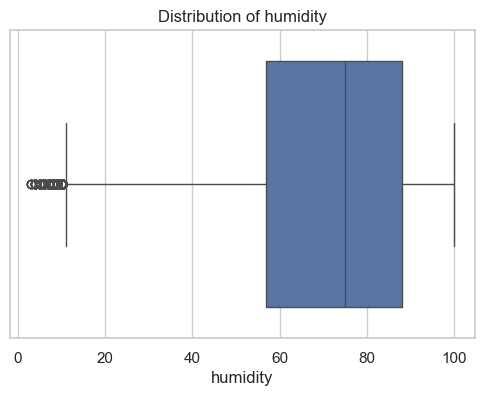

In [1224]:
visualize_data(city_weather, 'humidity')

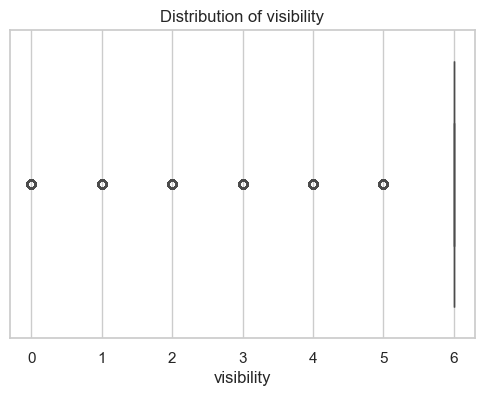

In [1225]:
visualize_data(city_weather, 'visibility')

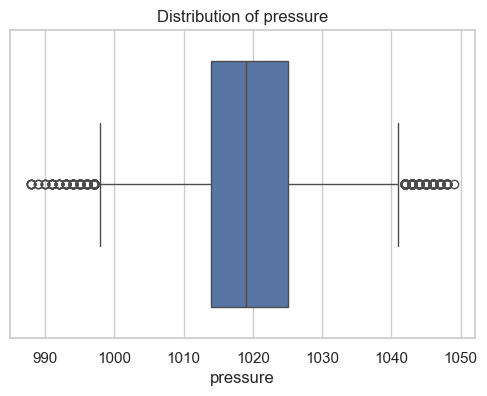

In [1226]:
visualize_data(city_weather, 'pressure')

In [1227]:
city_weather.shape

(55176, 11)

In [1228]:
# Display the count of each unique value in the 'precip' column
precip_counts = city_weather['precip'].value_counts()
print(precip_counts)

precip
0.0    53531
0.1     1405
0.2      170
0.3       48
0.4       10
0.5        9
0.6        2
0.8        1
Name: count, dtype: int64


In [1229]:
precip_counts = city_weather['visibility'].value_counts()
print(precip_counts)

visibility
6    41518
1     3770
4     3658
3     2349
5     1545
2     1458
0      878
Name: count, dtype: int64


In [1230]:
city_weather = drop_columns(city_weather, ['precip','visibility'])

In [1231]:
city_weather.columns

Index(['city_id', 'date', 'hour', 'temp', 'wind_speed', 'description',
       'humidity', 'pressure', 'datetime'],
      dtype='object')

In [1232]:
#city_weather = remove_outliers(city_weather,['temp','pressure','hour','wind_speed','humidity'])

In [1233]:
city_weather.head(1)

,city_id,date,hour,temp,wind_speed,description,humidity,pressure,datetime
0,C-927ceb5e,2019-01-01,0000,30,11,Light snow,86,1019,2019-01-01


In [1234]:
city_weather = remove_outliers(city_weather)

In [1235]:
city_weather.head(5)

,city_id,date,hour,temp,wind_speed,description,humidity,pressure,datetime
0,C-927ceb5e,2019-01-01,0000,30,11,Light snow,86,1019,2019-01-01 00:00:00
1,C-927ceb5e,2019-01-01,0100,28,12,Light snow,86,1021,2019-01-01 01:00:00
2,C-927ceb5e,2019-01-01,0200,28,13,Moderate snow,85,1022,2019-01-01 02:00:00
3,C-927ceb5e,2019-01-01,0300,28,14,Moderate snow,84,1024,2019-01-01 03:00:00
4,C-927ceb5e,2019-01-01,0400,28,13,Moderate snow,84,1025,2019-01-01 04:00:00


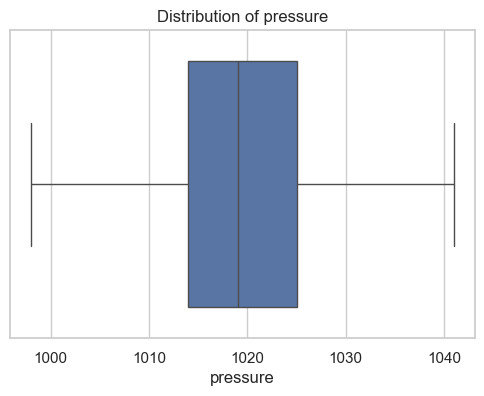

In [1236]:
visualize_data(city_weather, 'pressure')

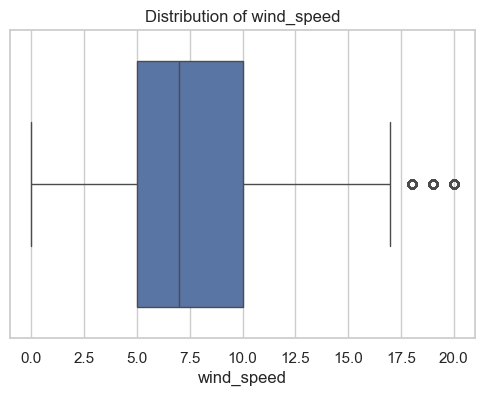

In [1237]:
visualize_data(city_weather, 'wind_speed')

In [1238]:
city_weather= add_index_and_eventtime_columns(city_weather)

In [1239]:
city_weather.shape

(52076, 11)

In [1240]:
city_weather.columns

Index(['city_id', 'date', 'hour', 'temp', 'wind_speed', 'description',
       'humidity', 'pressure', 'datetime', 'index', 'eventtime'],
      dtype='object')

In [1241]:
city_weather.head(5)

,city_id,date,hour,temp,wind_speed,description,humidity,pressure,datetime,index,eventtime
0,C-927ceb5e,2019-01-01,0000,30,11,Light snow,86,1019,2019-01-01 00:00:00,0,2024-09-19
1,C-927ceb5e,2019-01-01,0100,28,12,Light snow,86,1021,2019-01-01 01:00:00,1,2024-09-19
2,C-927ceb5e,2019-01-01,0200,28,13,Moderate snow,85,1022,2019-01-01 02:00:00,2,2024-09-19
3,C-927ceb5e,2019-01-01,0300,28,14,Moderate snow,84,1024,2019-01-01 03:00:00,3,2024-09-19
4,C-927ceb5e,2019-01-01,0400,28,13,Moderate snow,84,1025,2019-01-01 04:00:00,4,2024-09-19


In [1345]:
city_weather = drop_columns(city_weather, ['date','hour'])

In [1346]:
city_weather.isnull().sum()

city_id        0
temp           0
wind_speed     0
description    0
humidity       0
pressure       0
datetime       0
index          0
eventtime      0
dtype: int64

In [1349]:
city_weather.head(1)

,city_id,temp,wind_speed,description,humidity,pressure,datetime,index,eventtime
0,C-927ceb5e,30,11,Light snow,86,1019,2019-01-01,0,2024-09-19


In [1489]:
city_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52076 entries, 0 to 55175
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   city_id      52076 non-null  object        
 1   temp         52076 non-null  int64         
 2   wind_speed   52076 non-null  int64         
 3   description  52076 non-null  object        
 4   humidity     52076 non-null  int64         
 5   pressure     52076 non-null  int64         
 6   datetime     52076 non-null  datetime64[ns]
 7   index        52076 non-null  int64         
 8   eventtime    52076 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 4.0+ MB


In [1350]:
city_weather.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/city_weather_cleaned.csv', index=False)

Drivers table data cleaning

In [1351]:
drivers_table = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/drivers.csv')

In [1352]:
drivers_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   driver_id          1300 non-null   object 
 1   name               1300 non-null   object 
 2   gender             1277 non-null   object 
 3   age                1300 non-null   int64  
 4   experience         1300 non-null   int64  
 5   driving_style      1248 non-null   object 
 6   ratings            1300 non-null   int64  
 7   vehicle_no         1300 non-null   int64  
 8   average_speed_mph  1300 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 91.5+ KB


In [1353]:
drivers_table.head(5)

,driver_id,name,gender,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,d9f30553-6,Daniel Marks,male,47,5,proactive,7,42302347,62.22
1,82de7bb8-2,Clifford Carr,male,47,14,proactive,4,27867488,60.89
2,7e789842-4,Terry Faulkner MD,male,41,9,conservative,2,13927774,53.67
3,b2555587-8,Brendan Jacobs,male,44,10,proactive,2,69577118,59.82
4,b2e58421-d,Vincent Davis,male,41,10,proactive,7,28650047,62.65


In [1247]:
drivers_table.shape

(1300, 9)

In [1248]:
drivers_table.isnull().sum()

driver_id             0
name                  0
gender               23
age                   0
experience            0
driving_style        52
ratings               0
vehicle_no            0
average_speed_mph     0
dtype: int64

In [1355]:
display_unique_values(drivers_table)

Unique values in 'driver_id' (1300 total):
['d9f30553-6' '82de7bb8-2' '7e789842-4' ... '7e6a0cf5-1' 'c4a966b0-b'
 'e5d104b5-1']
Unique values in 'name' (1274 total):
['Daniel Marks' 'Clifford Carr' 'Terry Faulkner MD' ... 'Richard Ortiz'
 'Peter Rodriguez' 'Michael Robinson']
Unique values in 'gender' (3 total):
['male' 'female' nan]
Unique values in 'age' (36 total):
[47 41 44 49 54 48 40 56 46 50 55 45 51 43 61 53 37 57 42 52 60 39 59 58
 62 38 36 65 32 28 30 64 34 29 33 35]
Unique values in 'experience' (41 total):
[ 5 14  9 10 17  0  6 19 13 18 11 25 23  4  7 15 24 16  8 22 12 26  2 27
  3 28 21 20 31 -7  1 29 -2 30 -3 -5 -1 -4 32 35 -8]
Unique values in 'driving_style' (3 total):
['proactive' 'conservative' nan]
Unique values in 'ratings' (8 total):
[7 4 2 9 3 8 6 5]
Unique values in 'vehicle_no' (1300 total):
[42302347 27867488 13927774 ... 21865328 33564827 34755903]
Unique values in 'average_speed_mph' (978 total):
[62.22 60.89 53.67 59.82 62.65 57.66 40.79 61.7  42.15 46.49 62

In [1356]:
#drivers_table = drop_columns(drivers_table, ['unwanted_col'])

In [1357]:
drivers_table = remove_duplicates(drivers_table)

In [1358]:
drivers_table = filling_missing_values(drivers_table)

In [1359]:
drivers_table.isnull().sum()

driver_id            0
name                 0
gender               0
age                  0
experience           0
driving_style        0
ratings              0
vehicle_no           0
average_speed_mph    0
dtype: int64

In [1360]:
drivers_table.shape

(1300, 9)

In [1361]:
drivers_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   driver_id          1300 non-null   object 
 1   name               1300 non-null   object 
 2   gender             1300 non-null   object 
 3   age                1300 non-null   int64  
 4   experience         1300 non-null   int64  
 5   driving_style      1300 non-null   object 
 6   ratings            1300 non-null   int64  
 7   vehicle_no         1300 non-null   int64  
 8   average_speed_mph  1300 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 91.5+ KB


In [1362]:
drivers_table['vehicle_no'] = drivers_table['vehicle_no'].astype(object)


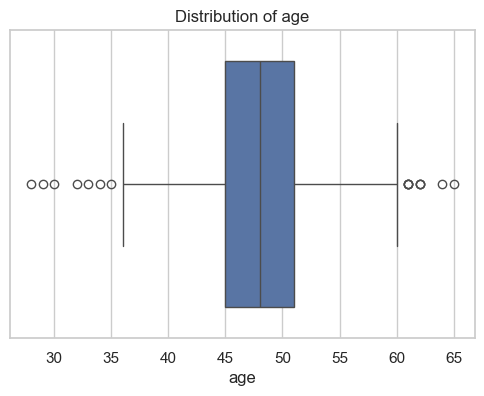

In [1363]:
visualize_data(drivers_table, 'age')

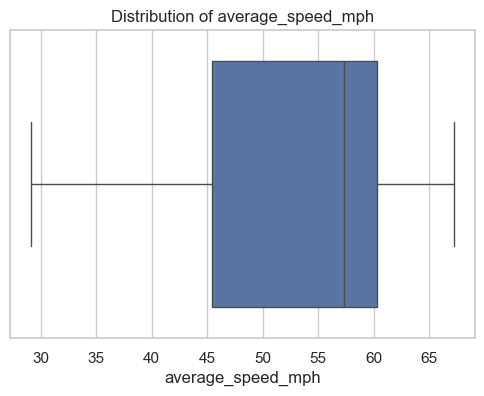

In [1364]:
visualize_data(drivers_table, 'average_speed_mph')

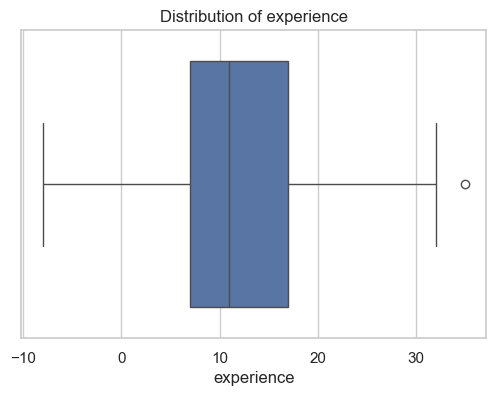

In [1365]:
visualize_data(drivers_table, 'experience')

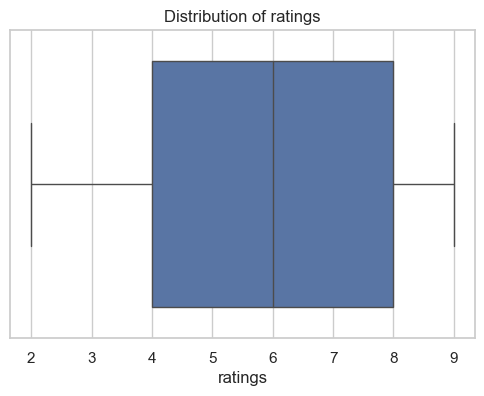

In [1366]:
visualize_data(drivers_table, 'ratings')

In [1367]:
drivers_table = remove_outliers(drivers_table)

In [1368]:
drivers_table.shape

(1283, 9)

In [1369]:
drivers_table = add_index_and_eventtime_columns(drivers_table)

In [1370]:
drivers_table.head(2)

,driver_id,name,gender,age,experience,driving_style,ratings,vehicle_no,average_speed_mph,index,eventtime
0,d9f30553-6,Daniel Marks,male,47,5,proactive,7,42302347,62.22,0,2024-09-19
1,82de7bb8-2,Clifford Carr,male,47,14,proactive,4,27867488,60.89,1,2024-09-19


In [1371]:
drivers_table.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/drivers_cleaned.csv', index=False)

Routes table data cleaning

In [1372]:
routes_table = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/routes.csv')

In [1373]:
routes_table.head(6)

,route_id,origin_id,destination_id,distance,average_hours
0,R-ada2a391,C-927ceb5e,C-56e39a5e,1735.06,34.70
1,R-ae0ef31f,C-927ceb5e,C-73ae5412,1498.24,29.96
2,R-4beec5fd,C-927ceb5e,C-4fe0fa24,6078.46,121.57
3,R-8d7a7fb2,C-927ceb5e,C-451776b7,1543.01,30.86
4,R-b236e347,C-927ceb5e,C-d80a1e7d,310.75,6.22
5,R-93f348a8,C-927ceb5e,C-c92599e2,1810.21,36.20


In [1374]:
routes_table.shape

(2352, 5)

In [1375]:
routes_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   route_id        2352 non-null   object 
 1   origin_id       2352 non-null   object 
 2   destination_id  2352 non-null   object 
 3   distance        2352 non-null   float64
 4   average_hours   2352 non-null   float64
dtypes: float64(2), object(3)
memory usage: 92.0+ KB


In [1376]:
routes_table.isnull().sum()

route_id          0
origin_id         0
destination_id    0
distance          0
average_hours     0
dtype: int64

In [1377]:
routes_table = remove_duplicates(routes_table)

In [1378]:
#routes_table = drop_columns(routes_table, ['unwanted_col'])

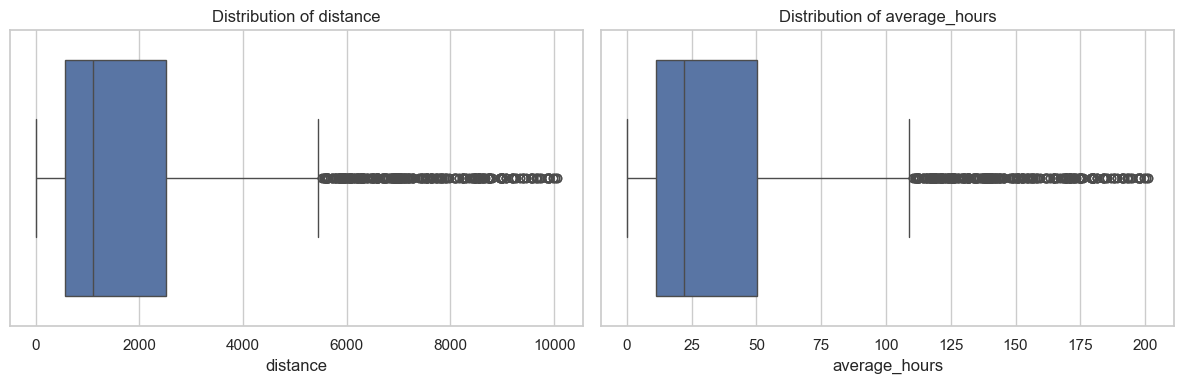

In [1379]:
visualize_data(routes_table, ['distance','average_hours']
               )

In [1380]:
routes_table = remove_outliers(routes_table)

In [1381]:
routes_table.shape

(1896, 5)

In [1382]:
routes_table = add_index_and_eventtime_columns(routes_table)

In [1383]:
routes_table.head(2)

,route_id,origin_id,destination_id,distance,average_hours,index,eventtime
0,R-ada2a391,C-927ceb5e,C-56e39a5e,1735.06,34.70,0,2024-09-19
1,R-ae0ef31f,C-927ceb5e,C-73ae5412,1498.24,29.96,1,2024-09-19


In [1384]:
routes_table.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/routes_cleaned.csv', index=False)

Route weather data cleaning

In [1385]:
routes_weather = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/routes_weather.csv')

In [1386]:
routes_weather.head(5)

,route_id,Date,temp,wind_speed,description,precip,humidity,visibility,pressure,chanceofrain,chanceoffog,chanceofsnow,chanceofthunder
0,R-ada2a391,2019-01-01 00:00:00,30,11,Heavy snow,0.0,90,1,1010,0,0,0,0
1,R-ada2a391,2019-01-01 06:00:00,30,11,Heavy snow,0.0,91,3,1012,0,0,0,0
2,R-ada2a391,2019-01-02 00:00:00,28,11,Cloudy,0.0,91,4,1013,0,0,0,0
3,R-ada2a391,2019-01-02 06:00:00,27,11,Cloudy,0.0,92,6,1015,0,0,0,0
4,R-ada2a391,2019-01-03 00:00:00,27,9,Cloudy,0.0,93,6,1016,0,0,0,0


In [1387]:
routes_weather.columns

Index(['route_id', 'Date', 'temp', 'wind_speed', 'description', 'precip',
       'humidity', 'visibility', 'pressure', 'chanceofrain', 'chanceoffog',
       'chanceofsnow', 'chanceofthunder'],
      dtype='object')

In [1388]:
routes_weather = drop_columns(routes_weather, ['chanceofrain', 'chanceoffog',
       'chanceofsnow', 'chanceofthunder'])

In [1389]:
routes_weather.columns

Index(['route_id', 'Date', 'temp', 'wind_speed', 'description', 'precip',
       'humidity', 'visibility', 'pressure'],
      dtype='object')

In [1390]:
routes_weather.isnull().sum()

route_id       0
Date           0
temp           0
wind_speed     0
description    0
precip         0
humidity       0
visibility     0
pressure       0
dtype: int64

In [1391]:
routes_weather = remove_duplicates(routes_weather)

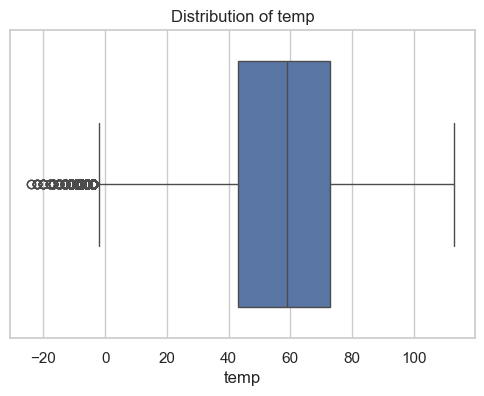

In [1392]:
visualize_data(routes_weather, 'temp')

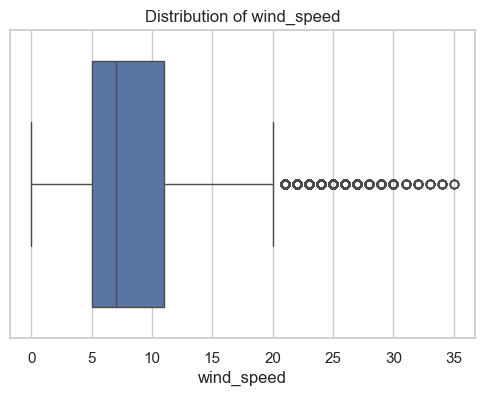

In [1393]:
visualize_data(routes_weather, 'wind_speed')

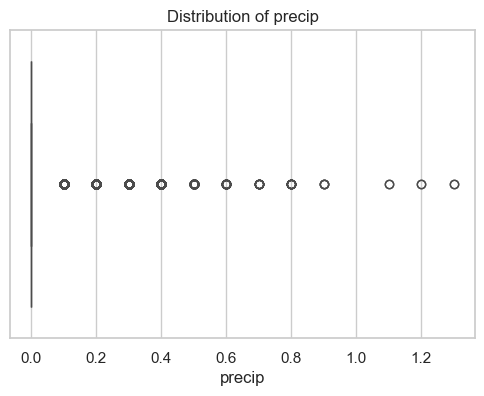

In [1394]:
visualize_data(routes_weather, 'precip')

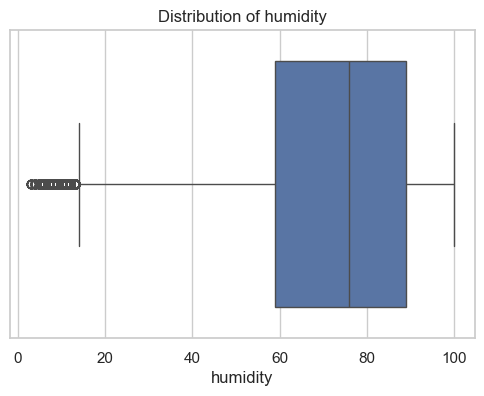

In [1395]:
visualize_data(routes_weather, 'humidity')

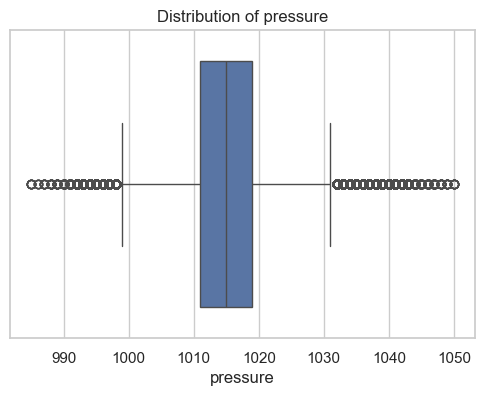

In [1396]:
visualize_data(routes_weather, 'pressure')

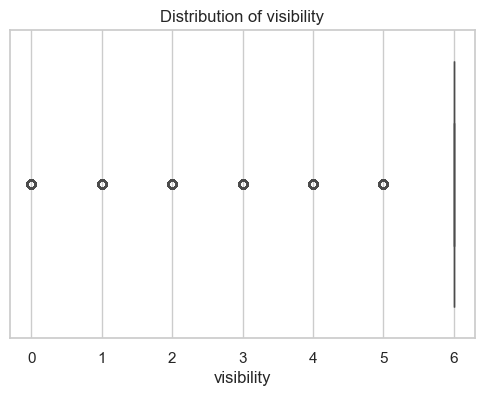

In [1397]:
visualize_data(routes_weather, 'visibility')

In [1398]:
routes_weather.shape

(425712, 9)

In [1399]:
routes_weather = remove_outliers(routes_weather)

In [1400]:
routes_weather.shape

(314931, 9)

In [1404]:
routes_weather = drop_columns(routes_weather, ['precip', 'visibility'])

In [1405]:
routes_weather = add_index_and_eventtime_columns(routes_weather)

In [1406]:
routes_weather.head(2)

,route_id,Date,temp,wind_speed,description,humidity,pressure,index,eventtime
3,R-ada2a391,2019-01-02 06:00:00,27,11,Cloudy,92,1015,0,2024-09-19
4,R-ada2a391,2019-01-03 00:00:00,27,9,Cloudy,93,1016,1,2024-09-19


In [1408]:
routes_weather.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/routes_weather_cleaned.csv', index=False)

Traffic table Data Cleaning

In [1409]:
traffic_table = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/traffic.csv')

In [1410]:
traffic_table.head(5)

,route_id,date,hour,no_of_vehicles,accident
0,R-ada2a391,2019-01-01,0,669.0,0
1,R-ada2a391,2019-01-01,100,628.0,0
2,R-ada2a391,2019-01-01,200,516.0,0
3,R-ada2a391,2019-01-01,300,582.0,0
4,R-ada2a391,2019-01-01,400,564.0,0


In [1411]:
display_unique_values(traffic_table,None)

Unique values in 'route_id' (2352 total):
['R-ada2a391' 'R-ae0ef31f' 'R-4beec5fd' ... 'R-0e0ac567' 'R-5ccd3200'
 'R-38a366a9']
Unique values in 'date' (46 total):
['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15'
 '2019-01-16' '2019-01-17' '2019-01-18' '2019-01-19' '2019-01-20'
 '2019-01-21' '2019-01-22' '2019-01-23' '2019-01-24' '2019-01-25'
 '2019-01-26' '2019-01-27' '2019-01-28' '2019-01-29' '2019-01-30'
 '2019-01-31' '2019-02-01' '2019-02-02' '2019-02-03' '2019-02-04'
 '2019-02-05' '2019-02-06' '2019-02-07' '2019-02-08' '2019-02-09'
 '2019-02-10' '2019-02-11' '2019-02-12' '2019-02-13' '2019-02-14'
 '2019-02-15']
Unique values in 'hour' (24 total):
[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300]
Unique values in 'no_of_vehicles' (2643 total):
[ 669.  628.  516. ..

In [1412]:
#traffic_table = drop_columns(traffic_table, ['unwanted_col'])

In [1475]:
traffic_table = combine_date_hour(traffic_table, 'date', 'hour')

In [1476]:
traffic_table.isnull().sum()

route_id          0
date              0
hour              0
no_of_vehicles    0
accident          0
datetime          0
index             0
eventtime         0
dtype: int64

In [1477]:
traffic_table.shape

(2597913, 8)

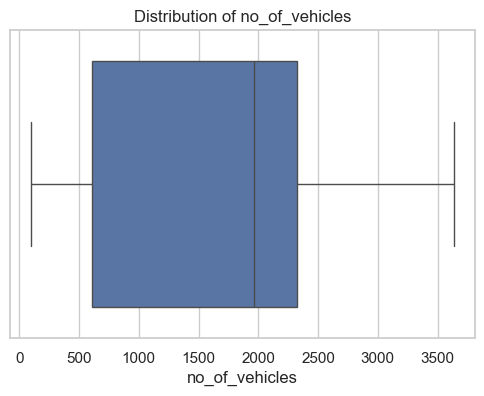

In [1478]:
visualize_data(traffic_table, 'no_of_vehicles')

In [1479]:
traffic_table = remove_duplicates(traffic_table)

In [1480]:
traffic_table = filling_missing_values(traffic_table)

In [1481]:
traffic_table.shape

(2597913, 8)

In [1482]:
#traffic_table = remove_outliers(traffic_table, 'traffic_table_column')

In [1483]:
traffic_table = add_index_and_eventtime_columns(traffic_table)

In [1485]:
traffic_table = drop_columns(traffic_table, ['date','hour'])

In [1486]:
traffic_table.head(2)

,route_id,no_of_vehicles,accident,datetime,index,eventtime
0,R-ada2a391,669.0,0,2019-01-01 00:00:00,0,2024-09-19
1,R-ada2a391,628.0,0,2019-01-01 01:00:00,1,2024-09-19


In [1487]:
traffic_table.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/traffic_cleaned.csv', index=False)

Truck Schedule Data cleaning

In [1424]:
truck_schedule_table = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/truck_schedule.csv')

In [1425]:
truck_schedule_table.head(5)

,truck_id,route_id,departure_date,estimated_arrival,delay
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12.000000000,0
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12.000000000,0
2,12602955,R-a3d67783,2019-01-01 07:00:00,2019-01-01 07:45:36.000000000,0
3,46619422,R-31ec9310,2019-01-01 07:00:00,2019-01-01 20:46:48.000000000,0
4,10140178,R-a07c5dbd,2019-01-01 07:00:00,2019-01-01 21:34:11.999999999,0


In [1426]:
#truck_schedule_table = drop_columns(truck_schedule_table, ['unwanted_col'])

In [1427]:
truck_schedule_table.shape

(12308, 5)

In [1428]:
truck_schedule_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12308 entries, 0 to 12307
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   truck_id           12308 non-null  int64 
 1   route_id           12308 non-null  object
 2   departure_date     12308 non-null  object
 3   estimated_arrival  12308 non-null  object
 4   delay              12308 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 480.9+ KB


In [1429]:
truck_schedule_table.isnull().sum()

truck_id             0
route_id             0
departure_date       0
estimated_arrival    0
delay                0
dtype: int64

In [1430]:
#truck_schedule_table = handle_missing_values(truck_schedule_table, method='fill')

In [1451]:
truck_schedule_table = remove_duplicates(truck_schedule_table)

In [1452]:
truck_schedule_table.head(2)

,truck_id,route_id,departure_date,estimated_arrival,delay
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12.000000000,0
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12.000000000,0


In [1453]:
truck_schedule_table = convert_estimated_arrival(truck_schedule_table, 'estimated_arrival')

In [1454]:
truck_schedule_table.head(2)

,truck_id,route_id,departure_date,estimated_arrival,delay
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12,0
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12,0


In [1455]:
truck_schedule_table = add_index_and_eventtime_columns(truck_schedule_table)

In [1456]:
truck_schedule_table.head(2)

,truck_id,route_id,departure_date,estimated_arrival,delay,index,eventtime
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12,0,0,2024-09-19
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12,0,1,2024-09-19


In [1457]:
truck_schedule_table.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/truck_schedule_cleaned.csv', index=False)

Truck Table Data cleaning

In [1458]:
trucks_table = pd.read_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/raw/trucks.csv')

In [1459]:
trucks_table.head(5)

,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type
0,42302347,10,3000.0,17,gas
1,27867488,14,10000.0,22,diesel
2,13927774,8,10000.0,19,gas
3,69577118,8,20000.0,19,gas
4,28650047,10,4000.0,21,diesel


In [1460]:
trucks_table.shape

(1300, 5)

In [1461]:
#trucks_table = drop_columns(trucks_table, ['unwanted_col'])

In [1462]:
trucks_table.isnull().sum()

truck_id                 0
truck_age                0
load_capacity_pounds    57
mileage_mpg              0
fuel_type               40
dtype: int64

In [1463]:
trucks_table = remove_duplicates(trucks_table)

In [1464]:
trucks_table = filling_missing_values(trucks_table)

In [1465]:
trucks_table.shape

(1300, 5)

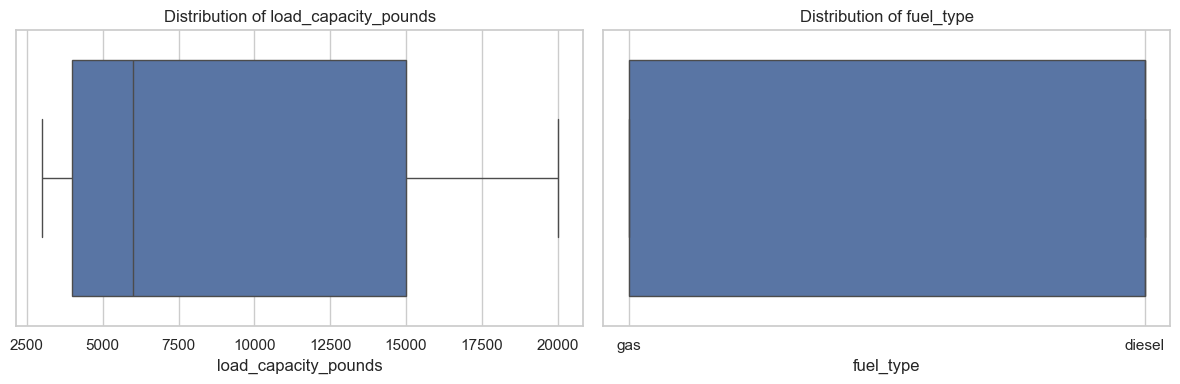

In [1466]:
visualize_data(trucks_table, ['load_capacity_pounds','fuel_type'])

In [1467]:
#trucks_table = remove_outliers(trucks_table, 'trucks_table_column')

In [1468]:
trucks_table = add_index_and_eventtime_columns(trucks_table)

In [1469]:
trucks_table.head(2)

,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type,index,eventtime
0,42302347,10,3000.0,17,gas,0,2024-09-19
1,27867488,14,10000.0,22,diesel,1,2024-09-19


In [1470]:
trucks_table.to_csv('/Users/jeevanapathipati/Documents/TruckDelay/data/cleaned/trucks_cleaned.csv', index=False)

In [1471]:
city_weather.columns

Index(['city_id', 'temp', 'wind_speed', 'description', 'humidity', 'pressure',
       'datetime', 'index', 'eventtime'],
      dtype='object')

In [1472]:
drivers_table.columns

Index(['driver_id', 'name', 'gender', 'age', 'experience', 'driving_style',
       'ratings', 'vehicle_no', 'average_speed_mph', 'index', 'eventtime'],
      dtype='object')

In [1473]:
routes_weather.columns

Index(['route_id', 'Date', 'temp', 'wind_speed', 'description', 'humidity',
       'pressure', 'index', 'eventtime'],
      dtype='object')

In [782]:
routes_table.columns

Index(['route_id', 'origin_id', 'destination_id', 'distance', 'average_hours',
       'index', 'eventtime'],
      dtype='object')

In [783]:
traffic_table.columns

Index(['route_id', 'date', 'hour', 'no_of_vehicles', 'accident', 'index',
       'eventtime'],
      dtype='object')

In [784]:
truck_schedule_table.columns

Index(['truck_id', 'route_id', 'departure_date', 'estimated_arrival', 'delay',
       'index', 'eventtime'],
      dtype='object')

In [785]:
trucks_table.columns

Index(['truck_id', 'truck_age', 'load_capacity_pounds', 'mileage_mpg',
       'fuel_type', 'index', 'eventtime'],
      dtype='object')

In [1490]:
traffic_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597913 entries, 0 to 2597912
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   route_id        object        
 1   no_of_vehicles  float64       
 2   accident        int64         
 3   datetime        datetime64[ns]
 4   index           int64         
 5   eventtime       datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 118.9+ MB
